# Phase 4 - Data Preparation (Computer Vision):
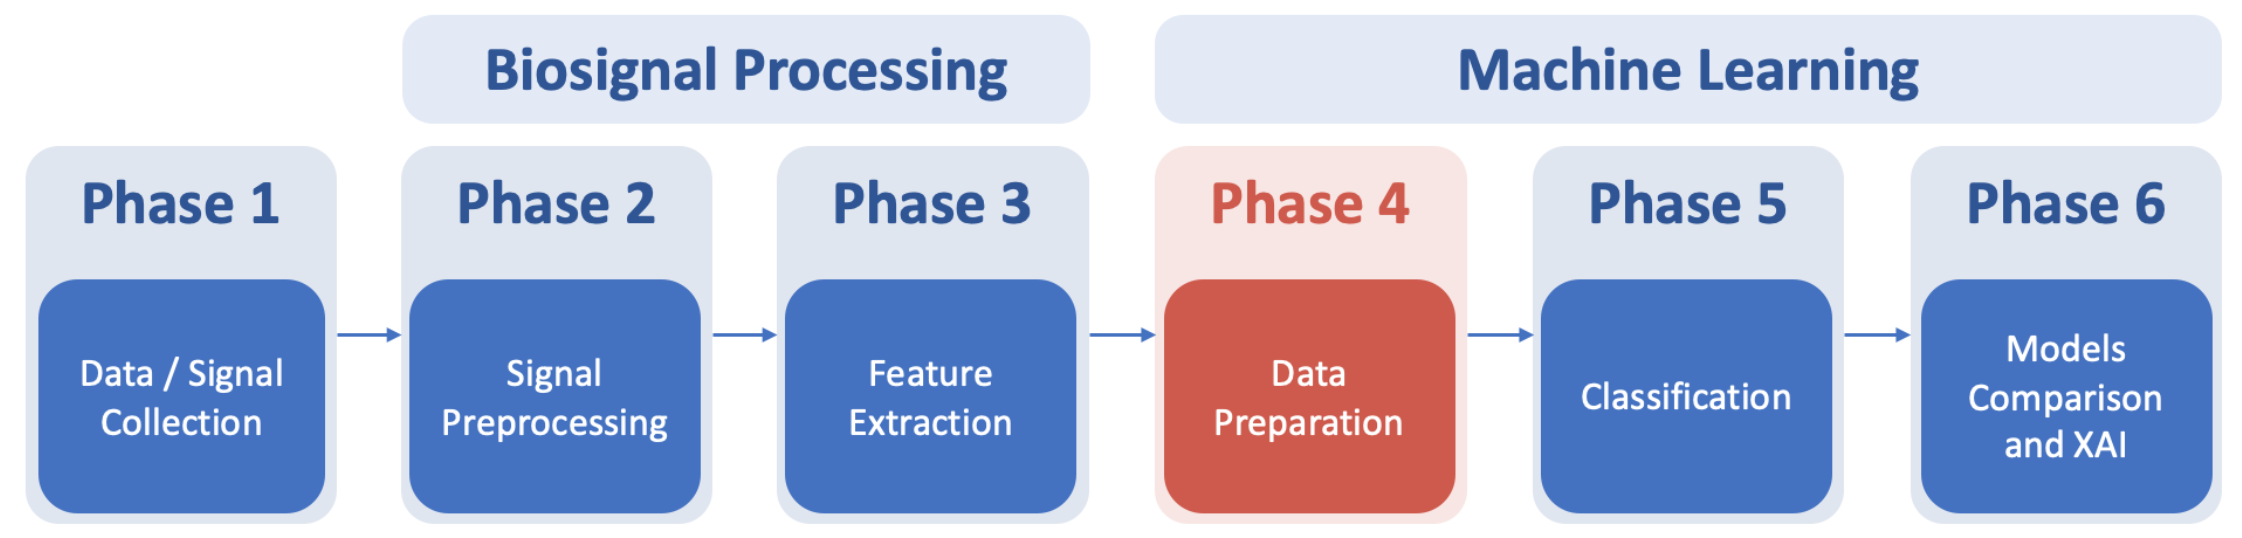
### Objective:
1. Applying Exploratory Data Analysis in order to understand the dataset.
2. Applying different techniques of Feature Engineering such as (Image resizing, Normalization, Image Resampling, Cross Validation).

### Notes:
- The images is imported from data directory, which has been extracted from Phonocardiogram signals in Phase 3 (Feature Extraction).
- All the functions and variables, which are used in this file, are imported from helpers.py file from the data_preparation package in the same repository.

In [1]:
# Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import random

import constants as c
from data_preparation.helpers import *

## 1. EDA:

### 1.1. Images' References:

In [3]:
REFERENCES = ExploratoryDataAnalysisCV.load_images_references(directory='/Users/mohammedlajam/Documents/GitHub/pcg-classification/data/extracted_features/images/scalogram/references.csv')
REFERENCES

,image_ref,signal_id,class
0,img_1,a0001,1
1,img_2,a0001,1
2,img_3,a0001,1
3,img_4,a0001,1
4,img_5,a0001,1
...,...,...,...
12604,img_12605,f0114,-1
12605,img_12606,f0114,-1
12606,img_12607,f0114,-1
12607,img_12608,f0114,-1


### 1.2. Images' Characteristics:

In [4]:
ExploratoryDataAnalysisCV.extract_initial_analysis(references=REFERENCES)

Number of Subjects: 12609
Classes: [ 1 -1]
Number of subjects per class:
 -1    9559
 1    3050
Name: class, dtype: int64


### 1.3. Images' Size:

In [1]:
# Usage example
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = ExploratoryDataAnalysisCV.get_random_image_size(directory=f'{c.PROCESSED_DATA_PATH}/images/scalogram')
print("Image width:", IMAGE_WIDTH)
print("Image height:", IMAGE_HEIGHT)
print('Number of channels:', IMAGE_CHANNELS)

NameError: name 'ExploratoryDataAnalysisCV' is not defined

### Observation:
- Total of 12609 Images
- Size of images are 1500x500 pixels
- Target Class (1 & -1)
- Images are not normalized
- Imbalanced Dataset (9559 and 3050 for Negative and Positive respectively)

## 2. Feature Engineering:

1. Loading Images and References:
- changing the -1 to 0
2. Resizing Images:
3. Cross Validation:
4. Normalization:
3. Image Resampling:

## 1. Loading Images and References:

In [6]:
import pickle

In [7]:
def _load_images_labels(rep_type: str):
    """Function to load the images and its labels from 'data/extracted_features/images' and
    return a numpy array lists of images and labels."""
    try:
        os.path.exists(f'{c.FEATURE_EXTRACTION_PATH}/images/{rep_type}')
    except Exception as e:
        print(e)
    else:
        image_dir = f'{c.FEATURE_EXTRACTION_PATH}/images/{rep_type}'
        # Loading References:
        references = pd.read_csv(f'{c.FEATURE_EXTRACTION_PATH}/images/{rep_type}/references.csv')

        images = []
        labels = []
        for index, row in references.iterrows():
            img_ref = row['image_ref'] + '.png'  # Adding file extension
            img_path = os.path.join(image_dir, img_ref)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            images.append(image)
            labels.append(row['class'])

        # Convert all -1 labels to 0:
        labels = [0 if label == -1 else label for label in labels]
        return images, labels, references

In [8]:
def _save_as_pickle_files(x_train, x_test, y_train, y_test, rep_type: str):
    """Function to save each fold as a pickle file in 'data/processed_data/images/scalogram' directory."""
    try:
        os.path.exists(f'{c.PROCESSED_DATA_PATH}/images/{rep_type}')
    except Exception as e:
        print(e)
    else:
        directory = f'data/processed_data/images/{rep_type}/'
        os.makedirs(directory, exist_ok=True)

        files = [('x_train.pkl', x_train), ('x_test.pkl', x_test), ('y_train.pkl', y_train), ('y_test.pkl', y_test)]
        for filename, data in files:
            file_path = os.path.join(directory, filename)
            with open(file_path, 'wb') as f:
                pickle.dump(data, f)
        return None

In [9]:
# Loading Images and its Labels:
IMAGES, LABELS, REFERENCES = _load_images_labels(rep_type='scalogram')

# Converting IMAGES and LABELS into Numpy arrays:
IMAGES = np.array(IMAGES, dtype=np.float32)
LABELS = np.array(LABELS)

In [11]:
# Resizing the images to 128x128:
RESIZED_IMAGES = FeatureEngineeringCV.resize_images(images=IMAGES, new_width=128, new_height=128)

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
@staticmethod
def split_images(images, labels, references, test_size, rand_state):
    """Function to split images into train and test set based on Group Stratified splitting."""
    group_splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=rand_state)

    # Convert references to groups
    groups = references['signal_id'].tolist()

    x_train, x_test, y_train, y_test = None, None, None, None  # Initialize the variables
    for train_index, test_index in group_splitter.split(images, labels, groups):
        x_train = [images[i] for i in train_index]
        x_test = [images[i] for i in test_index]
        y_train = [labels[i] for i in train_index]
        y_test = [labels[i] for i in test_index]
        break
    return x_train, x_test, y_train, y_test

In [33]:
# Splitting Images to train, test sets:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = split_images(images=RESIZED_IMAGES,
                                                labels=LABELS,
                                                references=REFERENCES,
                                                test_size=c.TEST_SIZE,
                                                rand_state=c.RANDOM_STATE)

In [55]:
X_TRAIN[0].shape

(128, 128)

In [39]:
X_TRAIN = np.array(X_TRAIN, dtype=np.float32)
X_TEST = np.array(X_TEST, dtype=np.float32)

In [67]:
def balance_images(images, labels, rand_state: int):
    """Function to balance images using SMOTE technique."""
    reshaped_images = images.reshape(images.shape[0], -1)
    smote = SMOTE(random_state=rand_state)

    images_resampled, labels_resampled = smote.fit_resample(reshaped_images, labels)
    # Reshape the resampled data back to the original shape
    images_resampled = images_resampled.reshape((-1, 128, 128))
    return images_resampled, labels_resampled

In [68]:
# Balancing images:
X_TRAIN_RESAMPLED, Y_TRAIN_RESAMPLED = balance_images(images=X_TRAIN,
                                                      labels=Y_TRAIN,
                                                      rand_state=c.RANDOM_STATE)

In [74]:
X_TRAIN_RESAMPLED.shape

(15294, 128, 128)

In [75]:
# Normalizing images:
X_TRAIN_NORMALIZED = FeatureEngineeringCV.normalize_images(images=X_TRAIN_RESAMPLED)
X_TEST_NORMALIZED = FeatureEngineeringCV.normalize_images(images=X_TEST)

In [79]:
X_TRAIN_NORMALIZED = np.array(X_TRAIN_NORMALIZED, dtype=np.float32)

In [82]:
X_TEST_NORMALIZED = np.array(X_TEST_NORMALIZED, dtype=np.float32)

In [89]:
# Saving images and labels in form of Pickle file:
_save_as_pickle_files(x_train=X_TRAIN_NORMALIZED,
                      x_test=X_TEST_NORMALIZED,
                      y_train=Y_TRAIN_RESAMPLED,
                      y_test=Y_TEST,
                      rep_type='scalogram')

# Cross Validation:

In [20]:
def create_cross_validation(images, labels, references, n_folds: int, rand_state: int):
    """Function to generate the indices for train and test set of each fold of the cross
    validation. It returns two list containing the indices for train and test sets."""
    cv = StratifiedGroupKFold(n_splits=n_folds, shuffle=True, random_state=rand_state)
    train_indices = []
    test_indices = []
    
    # Convert references to groups
    groups = references['signal_id'].tolist()
    for fold, (train_idx, test_idx) in enumerate(cv.split(images,
                                                          labels,
                                                          groups=groups)):
        train_indices.append(train_idx)
        test_indices.append(test_idx)
    return train_indices, test_indices

In [30]:
def create_lists_from_indices(images: list, labels: list, indices_list: list, index):
    """Function to return x and y based on the indices generated from cross-validation."""
    fold_indices = indices_list[index]
    image_fold = [images[i] for i in fold_indices]
    label_fold = [labels[i] for i in fold_indices]
    return image_fold, label_fold

In [21]:
TRAIN_INDICES, TEST_INDICES = create_cross_validation(images=RESIZED_IMAGES, 
                                                      labels=LABELS,
                                                      references=REFERENCES,
                                                      n_folds=c.N_FOLDS,
                                                      rand_state=c.RANDOM_STATE)

In [26]:
TEST_INDICES

[array([   31,    32,    33, ..., 12606, 12607, 12608]),
 array([    0,     1,     2, ..., 12600, 12601, 12602]),
 array([   35,    36,    37, ..., 12553, 12554, 12555]),
 array([   24,    25,    26, ..., 12571, 12572, 12573]),
 array([   83,    84,    85, ..., 12588, 12589, 12590]),
 array([    7,     8,     9, ..., 12541, 12542, 12543])]

In [31]:
IMAGE_FOLD_1, LABEL_FOLD_1 = create_lists_from_indices(images=RESIZED_IMAGES, 
                                                       labels=LABELS,
                                                       indices_list=TRAIN_INDICES,
                                                       index=0)

In [37]:
IMAGE_FOLD_1

[array([[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]], dtype=float32),
 array([[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]], dtype=float32),
 array([[255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        ...,
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.],
        [255., 255., 255., ..., 255., 255., 255.]], dtype=fl